In [9]:
pip install git+https://github.com/anedumla/quantum_linear_solvers

  Cloning https://github.com/anedumla/quantum_linear_solvers to /private/var/folders/tx/wpjdh33d6918ntvzx241gy3m0000gn/T/pip-req-build-7gmrxuoc
  Running command git clone --filter=blob:none --quiet https://github.com/anedumla/quantum_linear_solvers /private/var/folders/tx/wpjdh33d6918ntvzx241gy3m0000gn/T/pip-req-build-7gmrxuoc
  Resolved https://github.com/anedumla/quantum_linear_solvers to commit 08bf4f6673308568b5654e5d3fde9f8df5d887d7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.7/736.7 kB 8.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-3.0.11-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [26]:
import numpy as np
# testing example from the tutorial
from linear_solvers import NumPyLinearSolver, HHL
from qiskit.quantum_info import Statevector
#matrix = np.array([[1, -1/3], [-1/3, 1]])
#vector = np.array([1, 0])
#hhl_solution_package = HHL().solve(matrix, vector)

{   'circuit_results': None,
    'euclidean_norm': 0.11370558311706809,
    'observable': None,
    'state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14e56e310>}
512
solution?:  [ 7.07497212e-17-5.38807822e-16j  2.69749501e-16-1.21864324e-16j
 -2.27899297e-16+1.17744356e-16j -7.74912703e-16-7.09645511e-16j
  1.03549133e-01+5.26334252e-15j -4.15600126e-02+1.07255212e-02j
  1.31282246e-02-1.38533375e-02j -2.34463503e-17+1.03837458e-15j]


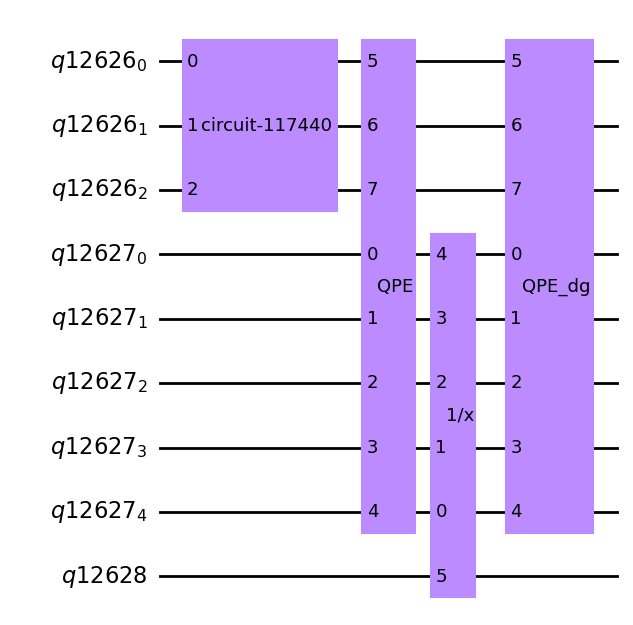

In [36]:
# Trying to get this to work with built-in HHL - weird overflow error
# Define a 3x3 non-hermitian matrix
A = np.array([
    [1 + 1j, 2 - 1j, 3],
    [4 + 2j, 5, 6 - 1j],
    [7 - 3j, 8 + 1j, 9]
], dtype=complex)

# Construct H (6x6 Hermitian matrix)
A_padded = np.array([
    [1 + 1j, 2 - 1j, 3, 0],
    [4 + 2j, 5, 6 - 1j, 0],
    [7 - 3j, 8 + 1j, 9, 0],
    [0,0,0,0]
], dtype=complex)
h_matrix = np.block([
    [np.zeros((4, 4), dtype=complex), A_padded],
    [A_padded.conj().T, np.zeros((4, 4), dtype=complex)]
])
# print(h_matrix)

#padded_hmatrix = np.zeros((8, 8), dtype=complex)
#padded_hmatrix[:6, :6] = h_matrix

#epsilon = 1e-6  # Small regularization parameter
#h_matrix = h_matrix + epsilon * np.eye(h_matrix.shape[0])


vector = np.array([1, 0, 0, 0, 0, 0], dtype=complex)  # Example vector
padded_vector = np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=complex) 

test_matrix = np.array([
    [9, -1j, 3, 0],
    [1j, 2, 8 - 1j, 0],
    [3, 8 + 1j, 3, 0],
    [0,0,0,1]
], dtype=complex)
test_matrix_8 = np.block([
    [np.zeros((4, 4), dtype=complex), test_matrix],
    [test_matrix.conj().T, np.zeros((4, 4), dtype=complex)]
])
# print(test_matrix == test_matrix.conj().T)
hhl_solution_package = HHL().solve(test_matrix_8, [1,0,0,0,0,0,0,0])
# Generate HHL circuit
# hhl_solution_package = HHL().solve(h_matrix, padded_vector)
print(hhl_solution_package)

sv_package = Statevector(hhl_solution_package.state).data
print(len(sv_package))
# extract vector components; 10000(bin) == 16 & 10001(bin) == 17
#full_vector_package = np.array([sv_package[16], sv_package[17]])

#print('HHL package solution vector:', full_vector_package)
# print(Statevector(hhl_solution_package.state).data)
print("solution?: ", sv_package[256:256+8])
hhl_solution_package.state.draw('mpl')

# print('full solution vector:', get_solution_vector(hhl_solution_package))


In [40]:
result = NumPyLinearSolver().solve(test_matrix_8, [1,0,0,0,0,0,0,0])
print(result.state)


[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.10573477+0.j         -0.04301075+0.01075269j
  0.0125448 -0.01433692j  0.        +0.j        ]


In [ ]:
# HHL for a 6x6 matrix and 6x1 vector
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector

# returns an HHL circuit for a given matrix vector
def get_hhl_circuit(matrix, vector):
    # find number of qubits needed for the input and clock registers
    original_size = len(vector)
    padded_size = 1 << (original_size - 1).bit_length()  # needs to be power of 2
    input_qubits = int(np.log2(padded_size))

    clock_qubits = input_qubits 
    ancilla_qubits = 1

    qc = QuantumCircuit(clock_qubits + input_qubits + ancilla_qubits)

    # encode and pad the input state |b>
    b_norm = np.linalg.norm(vector)
    b_state = vector / b_norm 

    # pad the vector to the nearest power of 2
    if len(b_state) < padded_size:
        b_state = np.pad(b_state, (0, padded_size - len(b_state)), 'constant')

    qc.initialize(b_state, range(clock_qubits, clock_qubits + input_qubits))


    # apply QPE
    # add Hadamard gates to clock qubits
    qc.h(range(clock_qubits))

    # Construct a unitary matrix U based on the input Hermitian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    U_matrix = eigenvectors @ np.diag(np.exp(2j * np.pi * eigenvalues)) @ np.linalg.inv(eigenvectors)

    # Pad U_matrix to the next power of 2 if needed
    if U_matrix.shape[0] < padded_size:
        padded_U = np.eye(padded_size, dtype=complex)
        padded_U[:U_matrix.shape[0], :U_matrix.shape[1]] = U_matrix
        U_matrix = padded_U

    U_gate = UnitaryGate(U_matrix, label="U")

    for i in range(clock_qubits):
        qc.append(U_gate.control(1), [i, *range(clock_qubits, clock_qubits + input_qubits)])

    # Apply inverse QFT to clock qubits
    qc.append(QFT(clock_qubits, inverse=True).to_gate(), range(clock_qubits))

    # Apply the R(1/\lambda) rotation
    for i in range(clock_qubits):
        qc.cry(2 * np.pi / (2**i), clock_qubits - i - 1, clock_qubits + input_qubits)

    # Uncompute using inverse QPE
    qc.append(QFT(clock_qubits).to_gate(), range(clock_qubits))
    for i in range(clock_qubits):
        qc.append(U_gate.control(1).inverse(), [i, *range(clock_qubits, clock_qubits + input_qubits)])

    qc.h(range(clock_qubits))

    # Measure the ancilla qubit
    qc.measure_all()

    return qc

# solves HHL for a given matrix and vector
def solve_hhl(matrix, vector):
    qc = get_hhl_circuit(matrix, vector)

    # Simulate the circuit
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    statevector = Statevector(result.get_statevector(qc))

    # Extract the solution vector components from the statevector
    # solution_indices = [16, 17] # these are wrong
    # print(statevector.data)
    # solution_vector = np.array([statevector.data[i] for i in solution_indices])

    return statevector.data # returning for debugging

# Define a 6x6 Hermitian matrix and input vector
A = np.array([
    [1 + 1j, 2 - 1j, 3],
    [4 + 2j, 5, 6 - 1j],
    [7 - 3j, 8 + 1j, 9]
], dtype=complex)

# Construct H (6x6 Hermitian matrix)
h_matrix = np.block([
    [np.zeros((3, 3), dtype=complex), A],
    [A.conj().T, np.zeros((3, 3), dtype=complex)]
])
padded_hmatrix = np.zeros((8, 8), dtype=complex)
padded_hmatrix[:6, :6] = h_matrix


# epsilon = 1e-6  # Small regularization parameter
# regularized_matrix = padded_hmatrix + epsilon * np.eye(padded_hmatrix.shape[0])


vector = np.array([1, 0, 0, 0, 0, 0], dtype=complex)  # Example vector
padded_vector = np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=complex) 

# Generate HHL circuit
# hhl_circuit_ours = solve_hhl(padded_hmatrix, padded_vector)
hhl_solution_package = HHL().solve(padded_hmatrix, padded_vector)
# print(hhl_circuit_ours)
print(hhl_solution_package)


OverflowError: cannot convert float infinity to integer

In [ ]:
# small test
# Define a 6x6 Hermitian matrix and input vector
h_matrix = np.array([
    [1+1j, 2j],
    [-2j, 5+10j]
], dtype=complex)


vector = np.array([1, 0, 0, 0, 0, 0], dtype=complex)  # Example vector
padded_vector = np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=complex) 

# Generate HHL circuit
# hhl_circuit_ours = solve_hhl(padded_hmatrix, padded_vector)
hhl_solution_package = HHL().solve(regularized_matrix, padded_vector)
# print(hhl_circuit_ours)
print(hhl_solution_package)

In [11]:
from qiskit.quantum_info import Statevector

sv_package = Statevector(hhl_solution_package.state).data

# extract vector components; 10000(bin) == 16 & 10001(bin) == 17
full_vector_package = np.array([sv_package[16], sv_package[17]])

print('HHL package solution vector:', full_vector_package)

solution vector: [0.75+3.58786629e-16j 0.25+1.71056924e-16j]


In [13]:
def get_solution_vector(solution):
    """Extracts and normalizes simulated state vector
    from LinearSolverResult."""
    solution_vector = Statevector(solution.state).data[16:18].real
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)

print('full solution vector:', get_solution_vector(hhl_solution_package))

full solution vector: [1.125 0.375]
